### Long term to-do:
Get NFL dataset for comparison

Get Twitter data for comparison

In [2]:
import json
import nltk
import string
from datetime import datetime
import pandas as pd
import dask.dataframe as dd
from dask import get
import numpy as np
from ast import literal_eval
from fuzzywuzzy import process as fuzzy_process
from fuzzywuzzy import fuzz
from string import punctuation
from sner import Ner
from nltk import word_tokenize, sent_tokenize, pos_tag, ne_chunk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
# download stanford core nlp (should be a zip file of format stanford-ner-YYYY-MM-DD) (maybe from https://nlp.stanford.edu/software/CRF-NER.shtml#Download)
# need to start the Java server:
# cd C:\ProgramData\Anaconda3\Lib\site-packages\sner\stanford-ner-2018-02-27
# java -Djava.ext.dirs=./lib -cp stanford-ner.jar edu.stanford.nlp.ie.NERServer -port 9199 -loadClassifier ./classifiers/english.all.3class.distsim.crf.ser.gz  -tokenizerFactory edu.stanford.nlp.process.WhitespaceTokenizer -tokenizerOptions tokenizeNLs=false

In [49]:
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', 100)

## Constants and non-text data

In [5]:
non_players_set = set('Atlanta Hawks Boston Celtics Brooklyn Nets Charlotte Bobcats' \
                  'Chicago Bulls Cleveland Cavaliers cavs Dallas Mavericks mavs Denver Nuggets ' \
                  'Detroit Pistons Golden State Warriors Houston Rockets Indiana'\
                  'Pacers Los Angeles LA Clippers LA Lakers LAL Memphis Grizzlies Miami Heat '\
                  'Milwaukee Bucks Minnesota Timberwolves  New Orleans Hornets New York Knicks NYK '\
                  'Oklahoma City Thunder Orlando Magic Philadelphia Sixers 76ers Phoenix'\
                  'Suns Portland Trail Blazers Sacramento Kings'\
                  'San Antonio Spurs Toronto Raptors Utah Jazz Washington Wizards wiz'\
                      'NBA asg'.lower().split())

### Instantiate sentiment analyzer

In [6]:
sid = SentimentIntensityAnalyzer()
stat_words = ['steal', 'steals', 'block', 'blocked', 'blocks', 'slam', 'charges', 'rejection', 'free', 'assists']
neutral_words = ['offense', 'offensive', 'offensively', 'defense', 'defensive', 'defensively', 'defender',
                 'injury', 'injured', 'strain', 'questionable', 'isolation',
                 'shoot', 'doubtful', 'play', 'plays', 'crazy', 'turnover', 'turnovers',
                 'seriously']
bad_words = ['foul', 'vicious', 'ridiculous', 'motherfucking', 'mediocre', 'soft']
great_words = ['goat', 'nasty', 'prime']
sid.lexicon.update({word:0.1 for word in stat_words})
sid.lexicon.update({word:0 for word in neutral_words})
sid.lexicon.update({word:-0.5 for word in bad_words})
sid.lexicon.update({word:1 for word in great_words})

### Load player demographic and performance data

In [288]:
demo_df = pd.read_csv('data/players2018.tsv', sep ='\t', encoding = 'utf-8')
demo_df['Player'] = demo_df['Player'].str.lower()

Fix heights

In [289]:
demo_df['Ht'] = demo_df['Ht'].str.split('-')
height_dict = {'Jun':72, 'Jul':84, 'May':60}
height_dict.update({str(x):x for x in range(13)})
height_dict.update({'00':0})
demo_df['Ht'] = demo_df['Ht'].apply(lambda row: height_dict[row[0]] + height_dict[row[1]])

In [290]:
performance_df = (pd.read_html('https://www.basketball-reference.com/leagues/NBA_2018_advanced.html')[0]
                    .drop_duplicates('Player', keep = 'first')
                     .query('Player != "Player"'))
performance_df['Player'] = performance_df['Player'].str.lower()

In [291]:
for col in ['PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%',
            'OWS', 'DWS', 'WS', 'WS/48', 'OBPM','DBPM', 'BPM', 'VORP']:
    performance_df[col] = performance_df[col].astype(float)

In [292]:
#team_df = pd.concat(pd.read_html('https://www.basketball-reference.com/leagues/NBA_2018.html')[:2])
team_df = pd.read_csv('data/teams2018.tsv', sep='\t')

In [293]:
demo_df = demo_df.merge(performance_df, on = 'Player').merge(team_df, on='Tm')
demo_df.head(2)

,Player,From,To,Pos_x,Ht,Wt,Birth Date,Colleges,experience,Race,Rk,Pos_y,Age,Tm,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,Unnamed: 19,OWS,DWS,WS,WS/48,Unnamed: 24,OBPM,DBPM,BPM,VORP,Wins
0,alex abrines,2017,2018,G-F,78,190,1-Aug-93,NaN,1,W,1,SG,24,OKC,75,1134,9.0,0.567,0.759,0.158,2.5,8.9,5.6,3.4,1.7,0.6,7.4,12.7,NaN,1.3,1.0,2.2,0.094,NaN,-0.5,-1.7,-2.2,-0.1,48
1,steven adams,2014,2018,C,84,255,20-Jul-93,University of Pittsburgh,4,W,3,C,24,OKC,76,2487,20.6,0.630,0.003,0.402,16.6,13.9,15.3,5.5,1.8,2.8,13.2,16.7,NaN,6.7,3.0,9.7,0.187,NaN,2.2,1.1,3.3,3.3,48


#### Player names for entity recognition and fuzzy matching

In [90]:
UNIQUE_NAMES = set(demo_df.Player.unique())

In [91]:
PLAYER_ENTITIES = set(' '.join(UNIQUE_NAMES).split()).union({'lma', 'kd', 'lbj','klove', 'drose', 'kobe', 'mj', 'magic', 'bird', 'wilt', 'chamberlain'})
# some players have common word names; don't want to detect those as entities when lowercase, but do want to when uppercase
UPPER_ENTITIES = {'Love', 'Smart', 'Rose', 'Black', 'White', 'Wear', 'Ball', 'Will', 'Buddy', 'Temple', 'Brown', 'Grant', 'Smart', 'Holiday', 'Stone'}
PLAYER_ENTITIES = PLAYER_ENTITIES - {'a'} - {name.lower() for name in UPPER_ENTITIES}
table = str.maketrans({key: None for key in string.punctuation})
NOPUNCT_ENTITIES = {name.translate(table) for name in PLAYER_ENTITIES}
PLAYER_ENTITIES = PLAYER_ENTITIES.union(NOPUNCT_ENTITIES)

## Functions

In [12]:
def create_sentiment_df(comment_df_loc: str, ner_set = set(), non_players_set = {}, sentiment_analyzer=sid,
                        STR_COL = 'str_entities', FUZZY_COL='fuzzy_name'):
    ''' Main function that loads a month of player comments and:
        1. Separates comments into sentences
        2. Performs NER either via NLTK, or using pre-existing list of entities
        3. Calculates sentiment

    parameters:
        comment_df_loc: str for file location of gzipped player comments
        player_df: pandas dataframe with demographic and performance info on players
        ner_list: a list of named entities to save time for performing NER
        year_month: string for which month this is
    '''

    # load unprocessed comments (see notebook reddit-nba-scrape for details)
    print('Loading one month of player comments')
    comment_df = pd.read_csv(comment_df_loc, sep = '\t', encoding = 'utf-8')
    
    # get year_month
    try:
        comment_df['year_month'] = re.search('[0-9]{6}', comment_df_loc)[0]
    except:
        comment_df['year_month'] = None
    comment_df['text_length'] = comment_df['text'].str.len()
    print('Loaded {} comments'.format(comment_df.shape[0]))
    
    min_length = 20
    max_length = 500
    print('Filtering to comments with text_length > {} and text_length < {}'.format(min_length, max_length) )
    comment_df = comment_df.query('text_length > {} and text_length < {}'.format(min_length, max_length) )
    print('After filter, have {} comments'.format(comment_df.shape[0]))
    
    print('Chunking comments into sentences')
    sentences_df = chunk_comments_sentences(comment_df)
    
    print('Extracting named entities')
    if len(ner_set) > 0:
        ner_df = extract_known_ner(sentences_df, ner_set)
    else:
        ner_df = extract_unknown_ner(sentences_df)
        
    print('Cleaning entities')
    ner_df = clean_entities(ner_df, non_players_set=non_players_set)
        
    print('Calculating sentiment')
    sentiment_df = calculate_sentiment(ner_df, sid)
    
    print('Fuzzy matching player names')
    fuzzy_df = pd.DataFrame(sentiment_df[STR_COL].unique(), columns = [STR_COL])
    fuzzy_df[FUZZY_COL] = fuzzy_df[STR_COL].apply(find_player)
    sentiment_df = sentiment_df.merge(fuzzy_df, on=STR_COL)

    print('Returning {} sentences with clear player name'.format(sentiment_df.shape[0]))

    return ner_df, sentiment_df

In [13]:
def chunk_comments_sentences(comment_df: pd.DataFrame, text_col = 'text'):
    ''' Chunk comments into sentences using nltk `sent_tokenize`. Then re-joins to `comment_df` to retain other data
        comment_df: dataframe with a column for comments that need to be chunked
        text_col: column to be chunked
    '''
    
    # actual chunking
    print('Chunking into sentences')
    sentences_df = (pd.DataFrame(comment_df[text_col].apply(sent_tokenize).tolist(), index=comment_df.index)
                      .stack() )
    
    # rename stuff
    sentences_df = (sentences_df.reset_index()
                      .set_index('level_0')
                      .rename(columns={0:'sentences'})
                      .drop(['level_1'], axis = 1))
    sentences_df['sentences'] = sentences_df['sentences'].str.replace('\r|\n', ' ')
    
    print('Chunked into {} sentences'.format(sentences_df.shape[0]))
    return (comment_df.join(sentences_df)
                      .drop(columns = [text_col]) )

In [14]:
def extract_unknown_ner(sentences_df, SENTENCES_COL = 'sentences', NER_COL = 'named_entities', ner_port = 9199):
    ''' Extracted named entities using Stanford's NER.
        Requires a java server be already launched.
        sentences_df: pandas dataframe with one column that contains non-lowercased sentences
        SENTENCES_COL: name of column with sentences
        NER_COL: str name of column for output
    '''
    
    # filter to sentences long enough to have sentiment and player name
    min_length = 10 # characters
    sentences_df = sentences_df[sentences_df[SENTENCES_COL].str.len() >= min_length]
    
    # tag using Java
    pos_tagger = Ner(host='localhost',port=ner_port)
# would love to parallelize this, as it takes ~2-3 hours per year of data
#    ddf = dd.from_pandas(sentences_df)
    sner_entities = lambda text: [token for token, part in pos_tagger.get_entities(text ) if part in {'PERSON', 'ORGANIZATION', 'LOCATION'}]
    sentences_df[NER_COL] = sentences_df['sentences'].apply(lambda doc: sner_entities(doc))
    
    return sentences_df

In [15]:
def extract_known_ner(sentences_df: pd.DataFrame, NER_SET, UPPER_SET = {'Love', 'Smart', 'Rose'},
                      SENTENCES_COL = 'sentences', NER_COL = 'named_entities', UPPER_COL = 'upper_entities'):
    ''' Extract named entities from sentences, given known list of named entities (i.e. a list of players)
    
        ner_set: set of lower-cased named entities
    '''
    # First do an extraction for Love, Smart, etc.
    upper_filter = lambda sentence: list(filter(lambda word: word.strip(string.punctuation) in UPPER_SET, sentence.split() ))
    sentences_df[UPPER_COL] = sentences_df[SENTENCES_COL].apply(upper_filter)
    
    sentences_df[SENTENCES_COL] = sentences_df[SENTENCES_COL].str.lower()
    
    # tokenize sentence with split, and use filter to find named entities
    ner_filter = lambda sentence: list(filter(lambda word: word.strip(string.punctuation) in NER_SET, sentence.split() ))
    sentences_df[NER_COL] = sentences_df[SENTENCES_COL].apply(ner_filter)
    
    sentences_df[NER_COL] = sentences_df.apply(lambda row: row[NER_COL] + [word.lower() for word in row[UPPER_COL]], axis=1)
    
    return sentences_df

In [16]:
def clean_entities(sentences_df, NER_COL = 'named_entities', STR_COL = 'str_entities', non_players_set = {}):
    ''' Clean up the entities by
        1. Removing known non-player entities (e.g. teams, NBA, Coaches)
        2. Removing sentences that have 0 entities, or > 2 entities (i.e. multiple players)
    '''
    # clean up entities
    sentences_df[NER_COL] = sentences_df[NER_COL].apply(lambda entities: [entity.strip(punctuation) for entity in entities])
    sentences_df[NER_COL] = sentences_df[NER_COL].apply(lambda entities: [entity.lower() for entity in entities])
    
    # remove known non-player entities, and filter out rows with non-unique entities
    sentences_df[NER_COL] = sentences_df[NER_COL].apply(lambda entities: [entity for entity in entities if entity not in non_players_set])
    sentences_df = sentences_df[sentences_df[NER_COL].str.len() > 0] # only care if we can find entity
    sentences_df = sentences_df[sentences_df[NER_COL].str.len() <3]
    
    sentences_df[STR_COL] = sentences_df[NER_COL].apply(lambda entities: ' '.join(entities))
    
    print('Outputting {} sentences which have 1-2 named entities'.format(sentences_df.shape[0]))

    return sentences_df

In [17]:
def calculate_sentiment(sentences_df, sentiment_analyzer, SENTENCES_COL = 'sentences'):
    ''' Calculate sentiment of a sentence, probably using Vader
    '''

    # reset index to allow join to occur propoerly
    sentences_df = sentences_df.reset_index(drop=True)
    
    intermediate_df = sentences_df[SENTENCES_COL].apply(lambda sentence: sentiment_analyzer.polarity_scores(sentence) )
    sentiment_df = pd.DataFrame.from_dict(intermediate_df.tolist())
    sentences_df = sentences_df.join(sentiment_df)
    
    return sentences_df

In [18]:
def find_player( potential_name, unique_names = UNIQUE_NAMES):
    names = fuzzy_process.extractBests(potential_name, unique_names, score_cutoff=87) # 87 means that "klay kd" matches nothing, but "curry" matches "stephen curry"
    
    if (len(names) > 1 and names[0][1] == names[1][1]) or len(names) == 0:
    # no clear match, return 'unclear match'
        return 'unclear'
    # only one similar, or clear top similar
    return names[0][0]

## Load data
### Reddit
#### 2017 season

In [ ]:
%%time
_, oct_df = create_sentiment_df('data/201710-comments_submissions.tsv.gz', ner_set=PLAYER_ENTITIES)
_, nov_df = create_sentiment_df('data/201711-comments_submissions.tsv.gz', ner_set=PLAYER_ENTITIES)
_, dec_df = create_sentiment_df('data/201712-comments_submissions.tsv.gz', ner_set=PLAYER_ENTITIES)
_, jan_df = create_sentiment_df('data/201801-comments_submissions.tsv.gz', ner_set=PLAYER_ENTITIES)
_, feb_df = create_sentiment_df('data/201802-comments_submissions.tsv.gz', ner_set=PLAYER_ENTITIES)
_, mar_df = create_sentiment_df('data/201803-comments_submissions.tsv.gz', ner_set=PLAYER_ENTITIES)
_, apr_df = create_sentiment_df('data/201804-comments_submissions.tsv.gz', ner_set=PLAYER_ENTITIES)
_, may_df = create_sentiment_df('data/201805-comments_submissions.tsv.gz', ner_set=PLAYER_ENTITIES)

In [144]:
nba2017_df = pd.concat([oct_df, nov_df, dec_df, jan_df, feb_df, mar_df, apr_df, may_df])
nba2017_df.shape

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


(1312264, 17)

In [145]:
nba2017_df.to_csv('data/combined_months_ner_sentiment_2017.tsv', sep='\t',
               index=False, encoding = 'utf-8')

#### 2016 season

In [ ]:
%%time
_, oct_df = create_sentiment_df('data/201610-comments_submissions.tsv', ner_set=PLAYER_ENTITIES)
_, nov_df = create_sentiment_df('data/201611-comments_submissions.tsv', ner_set=PLAYER_ENTITIES)
_, dec_df = create_sentiment_df('data/201612-comments_submissions.tsv', ner_set=PLAYER_ENTITIES)
_, jan_df = create_sentiment_df('data/201701-comments_submissions.tsv', ner_set=PLAYER_ENTITIES)
_, feb_df = create_sentiment_df('data/201702-comments_submissions.tsv.gz', ner_set=PLAYER_ENTITIES)
_, mar_df = create_sentiment_df('data/201703-comments_submissions.tsv.gz', ner_set=PLAYER_ENTITIES)
_, apr_df = create_sentiment_df('data/201704-comments_submissions.tsv.gz', ner_set=PLAYER_ENTITIES)
_, may_df = create_sentiment_df('data/201705-comments_submissions.tsv.gz', ner_set=PLAYER_ENTITIES)

In [147]:
nba2016_df = pd.concat([oct_df, nov_df, dec_df, jan_df, feb_df, mar_df, apr_df, may_df])
nba2016_df.shape

(888935, 16)

In [148]:
nba2016_df.to_csv('data/combined_months_ner_sentiment_2016.tsv', sep='\t',
               index=False, encoding = 'utf-8')

#### Save / load

In [19]:
nba2016_df = pd.read_csv('data/combined_months_ner_sentiment_2016.tsv',sep='\t', encoding = 'utf-8')
nba2016_df['named_entities'] = nba2016_df['named_entities'].apply(literal_eval)
nba2017_df = pd.read_csv('data/combined_months_ner_sentiment_2017.tsv',sep='\t', encoding = 'utf-8').drop(columns='Unnamed: 0')
nba2017_df['named_entities'] = nba2017_df['named_entities'].apply(literal_eval)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (1,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Cleaning up name matches
Some extracted name entities don't have a clear match (e.g. "Rivers" could be Austin Rivers or Doc Rivers). Here we clean those out

In [23]:
name_map = {name:'unclear' for name in ['rivers', 'bird', 'draymond sessions', 'jalen jalen', 'brown markelle', 'kyrie korver', 'kyrie singler',
                    'wade drummond', 'kyrie anderson', 'kyle irving', 'kyle ingles', 'kyle turner', 'kyle turner', 'jabari maker',
                    'walton walton', 'nene kanter', 'courtney love', 'george will', 'charles charles', 'jason aaron', 'lebron jae',
                    'sterling lebron', 'bobby lebron', 'damien', 'cleveland', 'cleveland cleveland', 'ben ben', 'martin', "o'bryant",
                                       'sam sam']}
name_map.update({'giannis':'giannis antetokounmpo',
                'kd':'kevin durant',
                 'lbj':'lebron james',
                 'lma':'lamarcus aldridge'})

In [24]:
%%time
nba2017_df['fuzzy_name'] = nba2017_df.apply(lambda row: name_map[row['str_entities']] if row['str_entities'] in name_map else row['fuzzy_name'], axis=1)
nba2016_df['fuzzy_name'] = nba2016_df.apply(lambda row: name_map[row['str_entities']] if row['str_entities'] in name_map else row['fuzzy_name'], axis=1)

Wall time: 40.5 s


Remove players whose names have implicit sentiment

In [25]:
senti_players = ['jerian grant', 'jerami grant', 'marcus smart', 'justin holiday','jrue holiday', 'kevin love', 'derrick favors']
nba2017_df = nba2017_df[nba2017_df['fuzzy_name'].apply(lambda row: row not in senti_players)]
nba2016_df = nba2016_df[nba2016_df['fuzzy_name'].apply(lambda row: row not in senti_players)]

In [26]:
match_df = nba2017_df.query('fuzzy_name != "unclear"')
match_df.shape

(758386, 16)

#### First calculate the average sentiment for each player from each user

In [27]:
user_player_sentiment_df = (match_df.groupby(['fuzzy_name', 'user'])
                                    .agg({'compound':['mean', 'std', 'count']})
                                    .reset_index())
user_player_sentiment_df.columns = ['fuzzy_name', 'user', 'compound_mean', 'compound_std', 'comment_count']
user_player_sentiment_df.head(2)

,fuzzy_name,user,compound_mean,compound_std,comment_count
0,aaron brooks,666mafioso,0.6705,NaN,1
1,aaron brooks,76Answers,0.4927,NaN,1


#### Then calculate the average sentiment to players across all users

In [28]:
player_sentiment_df = (user_player_sentiment_df.query('compound_mean != 0')
                                               .groupby('fuzzy_name')
                                               .agg({'compound_mean':['mean', 'std', 'count']})
                                               .reset_index() )
player_sentiment_df.columns = ['fuzzy_name', 'compound_mean_mean', 'compound_mean_std', 'user_count']

### Exploration of sentiment alone
Plot of player popularity (number of users who comment on them), versus sentiment

Text(0,0.5,'Mean sentiment')

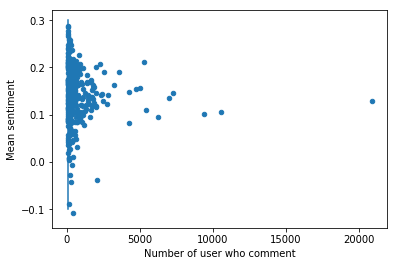

In [323]:
player_sentiment_df.query('user_count> 50').plot('user_count', 'compound_mean_mean', kind='scatter')
plt.plot([100, 100], [-0.1, 0.3])
plt.xlabel('Number of user who comment')
plt.ylabel('Mean sentiment')

#### Most commented players

In [30]:
player_sentiment_df.sort_values('user_count', ascending=False).head()

,fuzzy_name,compound_mean_mean,compound_mean_std,user_count
316,lebron james,0.128983,0.344258,20887
292,kevin durant,0.105746,0.379737,10575
212,james harden,0.101097,0.374204,9357
455,stephen curry,0.144980,0.371942,7281
308,kyrie irving,0.135729,0.378417,6983


#### Players with lowest sentiment

In [31]:
player_sentiment_df.query('user_count > 100').sort_values('compound_mean_mean').head()

,fuzzy_name,compound_mean_mean,compound_mean_std,user_count
456,sterling brown,-0.108161,0.452348,415
33,arron afflalo,-0.088347,0.462434,149
438,salah mejri,-0.041684,0.467865,309
527,zaza pachulia,-0.037957,0.428695,2041
232,jeff teague,-0.028511,0.465854,215


#### Players with highest sentiment

In [32]:
player_sentiment_df.query('user_count > 100').sort_values('compound_mean_mean').tail(5)

,fuzzy_name,compound_mean_mean,compound_mean_std,user_count
75,cole aldrich,0.251906,0.384975,211
392,og anunoby,0.252034,0.375970,142
325,luke kennard,0.257164,0.391741,220
143,ed davis,0.257536,0.370421,135
202,jakarr sampson,0.261270,0.362963,129


#### Players with highest std of sentiment

In [33]:
player_sentiment_df.query('user_count > 100').sort_values('compound_mean_std').tail(5)

,fuzzy_name,compound_mean_mean,compound_mean_std,user_count
124,devin harris,0.086920,0.469380,124
7,al jefferson,0.138065,0.473258,198
116,dennis schroder,0.057185,0.473741,201
275,julyan stone,0.087713,0.480701,315
253,johnny o'bryant,0.038065,0.485995,111


#### Join player sentiment to performance and demographics
Include only players with at least 100 comments to avoid fitting noise

In [294]:
join_df = (player_sentiment_df.query('user_count > 100')
                         .merge(demo_df, left_on = 'fuzzy_name', right_on = 'Player')
                          .drop(columns=['Unnamed: 19', 'Unnamed: 24']))
join_df['PER'] = pd.to_numeric(join_df['PER'])
join_df['Age'] = pd.to_numeric(join_df['Age'])
join_df['Wt'] = pd.to_numeric(join_df['Wt'])

### Explore demographics relationship with sentiment

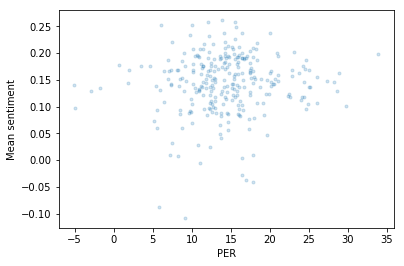

In [295]:
plt.plot(join_df['PER'].values, join_df['compound_mean_mean'].values, '.',alpha= 0.2);
plt.xlabel('PER')
plt.ylabel('Mean sentiment');

In [296]:
join_df.groupby('Race').mean()

,compound_mean_mean,compound_mean_std,user_count,From,To,Ht,Wt,experience,Age,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Wins
Race,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A,0.135601,0.430314,264.500000,2014.500000,2018.0,80.000000,205.000000,3.500000,25.500000,8.900000,0.446000,0.380500,0.479000,2.750000,7.200000,5.000000,14.600000,0.400000,4.80000,18.900000,24.050000,-0.250000,0.100000,-0.150000,-0.008500,-6.700000,-3.650000e+00,-10.350000,-0.150000,46.500000
B,0.141663,0.416854,886.864078,2012.325243,2018.0,78.500000,216.553398,5.674757,26.665049,14.268932,0.539893,0.332888,0.244718,4.384951,15.205825,9.794175,15.040777,1.656796,1.75000,12.895631,19.742718,1.766990,1.571845,3.341748,0.089850,-0.592718,-1.000000e-01,-0.693689,0.943689,42.432039
M,0.158856,0.412566,2074.625000,2011.875000,2018.0,77.750000,208.125000,6.125000,26.750000,17.200000,0.556250,0.306125,0.252375,4.487500,14.337500,9.550000,21.637500,1.900000,1.43750,14.237500,22.387500,2.500000,1.850000,4.337500,0.117125,1.325000,5.551115e-17,1.312500,1.550000,45.375000
R,0.015353,0.439793,243.500000,2017.000000,2018.0,81.500000,237.500000,1.000000,27.500000,11.450000,0.541500,0.229000,0.372000,7.650000,18.700000,13.050000,7.150000,1.450000,4.90000,18.000000,14.950000,0.200000,1.050000,1.300000,0.080500,-4.050000,2.800000e+00,-1.250000,0.200000,39.500000
W,0.150787,0.410883,619.770492,2013.049180,2018.0,81.196721,229.000000,4.950820,26.901639,14.570492,0.574689,0.318689,0.343836,5.713115,18.190164,11.963934,11.554098,1.232787,1.85082,13.544262,18.339344,1.711475,1.488525,3.211475,0.111656,-0.618033,-1.344262e-01,-0.752459,0.821311,43.475410


#### Age / experience

Text(0,0.5,'Mean sentiment')

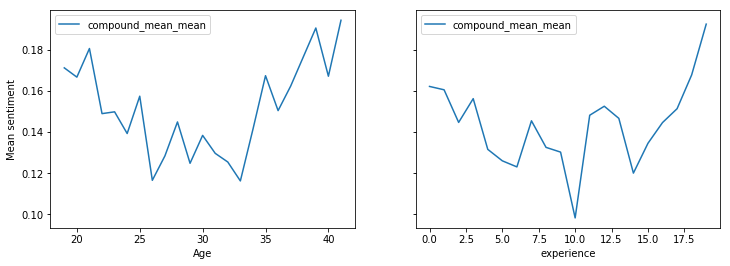

In [322]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = [12, 4], sharey=True)
join_df.groupby('Age').mean().reset_index().plot('Age', 'compound_mean_mean', ax = ax1);
join_df.groupby('experience').mean().reset_index().plot('experience', 'compound_mean_mean', ax = ax2);
ax1.set_ylabel('Mean sentiment')

In [298]:
join_df['youth'] = (join_df['Age'].mean() - join_df['Age']).clip(0)
join_df['oldness'] = (join_df['Age'] - join_df['Age'].mean()).clip(0)

#### Height

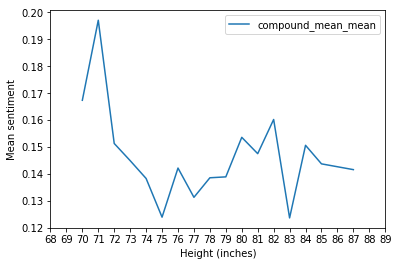

In [314]:
join_df.groupby('Ht').mean().reset_index().plot('Ht', 'compound_mean_mean');
plt.xticks(range(68,90,1) );
plt.xlabel('Height (inches)')
plt.ylabel('Mean sentiment');

In [300]:
join_df['height_dummies'] = pd.cut(join_df['Ht'], [0, 72, 79, 100], labels = ['short', 'medium', 'tall'])

### Team and position

In [315]:
join_df.groupby('Pos_y').mean().reset_index()

,Pos_y,compound_mean_mean,compound_mean_std,user_count,From,To,Ht,Wt,experience,Age,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Wins,youth,oldness,A,B,M,R,W,short,medium,tall,ATL,BOS,BRK,CHI,CLE,DAL,DEN,DET,GSW,HOU,IND,LAC,LAL,MEM,MIA,MIL,MIN,NOP,NYK,OKC,ORL,PHI,PHO,POR,SAC,SAS,TOR,UTA,WAS
0,C,0.149212,0.414816,678.477612,2011.686567,2018.0,83.014925,249.582090,6.313433,27.417910,16.865672,0.577015,0.117582,0.402970,9.695522,23.034328,16.389552,10.656716,1.291045,3.504478,14.949254,18.386567,2.162687,1.798507,3.961194,0.133284,-1.055224,1.553731,0.491045,1.173134,43.686567,1.745359,2.446424,0.014925,0.567164,0.014925,0.014925,0.388060,0.000000,0.000000,1.000000,0.014925,0.044776,0.014925,0.029851,0.044776,0.044776,0.014925,0.014925,0.074627,0.044776,0.044776,0.029851,0.059701,0.014925,0.044776,0.029851,0.044776,0.029851,0.044776,0.014925,0.044776,0.044776,0.014925,0.059701,0.014925,0.044776,0.029851,0.014925,0.029851
1,PF,0.139360,0.414920,1226.170213,2012.595745,2018.0,81.191489,232.702128,5.404255,26.297872,14.853191,0.549277,0.371894,0.228787,5.682979,18.353191,12.006383,10.831915,1.327660,2.110638,11.651064,19.661702,2.044681,1.806383,3.855319,0.099830,-0.427660,0.021277,-0.410638,1.042553,42.297872,2.180584,1.761611,0.000000,0.787234,0.021277,0.000000,0.191489,0.000000,0.148936,0.851064,0.021277,0.042553,0.021277,0.042553,0.042553,0.021277,0.063830,0.021277,0.042553,0.042553,0.021277,0.000000,0.021277,0.000000,0.063830,0.042553,0.042553,0.042553,0.042553,0.063830,0.042553,0.021277,0.063830,0.021277,0.042553,0.042553,0.042553,0.000000,0.021277
2,PG,0.141928,0.415818,920.327869,2013.180328,2018.0,74.819672,189.737705,4.819672,26.229508,14.342623,0.527508,0.348721,0.241197,2.255738,11.613115,6.934426,25.131148,1.800000,0.822951,14.778689,21.613115,1.608197,1.368852,2.983607,0.081525,-0.185246,-1.083607,-1.273770,0.924590,42.344262,2.055291,1.567953,0.016393,0.770492,0.065574,0.000000,0.147541,0.147541,0.836066,0.016393,0.032787,0.049180,0.049180,0.032787,0.032787,0.016393,0.016393,0.032787,0.049180,0.032787,0.000000,0.032787,0.032787,0.049180,0.049180,0.032787,0.032787,0.016393,0.049180,0.049180,0.000000,0.032787,0.032787,0.032787,0.016393,0.049180,0.049180,0.065574,0.032787
3,SF,0.147896,0.413665,587.534884,2012.488372,2018.0,79.674419,218.348837,5.511628,26.906977,12.604651,0.547535,0.387465,0.229372,2.937209,14.118605,8.539535,10.181395,1.751163,1.395349,11.658140,18.027907,1.306977,1.541860,2.858140,0.083023,-1.044186,-0.206977,-1.234884,0.737209,43.023256,1.838460,2.028590,0.000000,0.720930,0.000000,0.023256,0.255814,0.000000,0.395349,0.604651,0.000000,0.069767,0.046512,0.000000,0.023256,0.023256,0.046512,0.046512,0.046512,0.023256,0.023256,0.023256,0.069767,0.023256,0.000000,0.023256,0.023256,0.023256,0.000000,0.046512,0.046512,0.023256,0.046512,0.046512,0.046512,0.046512,0.046512,0.069767,0.046512
4,SG,0.137526,0.418528,879.032787,2012.737705,2018.0,77.065574,205.032787,5.262295,26.622951,12.483607,0.532803,0.465459,0.209492,2.096721,11.263934,6.677049,13.539344,1.662295,0.985246,11.777049,19.560656,1.524590,1.254098,2.783607,0.069443,-0.388525,-0.993443,-1.381967,0.677049,42.295082,1.903108,1.809213,0.000000,0.868852,0.032787,0.000000,0.098361,0.016393,0.967213,0.016393,0.016393,0.016393,0.016393,0.065574,0.049180,0.016393,0.032787,0.016393,0.049180,0.049180,0.032787,0.049180,0.032787,0.016393,0.032787,0.049180,0.032787,0.016393,0.049180,0.065574,0.032787,0.049180,0.032787,0.000000,0.032787,0.049180,0.032787,0.032787,0.032787


[Text(0,0,''),
 Text(0,0,'C'),
 Text(0,0,''),
 Text(0,0,'PF'),
 Text(0,0,''),
 Text(0,0,'PG'),
 Text(0,0,''),
 Text(0,0,'SF'),
 Text(0,0,''),
 Text(0,0,'SG')]

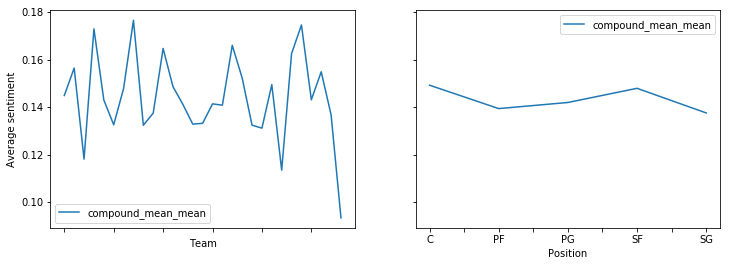

In [320]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = [12, 4], sharey=True)
join_df.groupby('Tm').mean().reset_index().plot('Tm', 'compound_mean_mean', ax = ax1);
ax1.set_xlabel('Team')
ax1.set_ylabel('Average sentiment')
join_df.groupby('Pos_y').mean().reset_index().plot('Pos_y', 'compound_mean_mean', ax = ax2);
ax2.set_xlabel('Position')
ax2.set_xticklabels(['', 'C','', 'PF','', 'PG','', 'SF','', 'SG'])

In [302]:
join_df.groupby('Tm').mean().sort_values('compound_mean_mean').head(2)

,compound_mean_mean,compound_mean_std,user_count,From,To,Ht,Wt,experience,Age,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Wins,youth,oldness
Tm,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
WAS,0.093305,0.422026,527.0,2012.0,2018.0,78.555556,212.444444,6.0,27.444444,14.666667,0.553778,0.289667,0.274889,4.788889,15.188889,10.00,16.50,1.70,1.577778,14.10,19.711111,2.033333,1.777778,3.822222,0.100333,-0.144444,-0.077778,-0.222222,1.00,43.0,1.127838,1.855436
PHO,0.113417,0.435604,413.3,2014.5,2018.0,79.100000,210.300000,3.5,24.200000,11.840000,0.517300,0.343300,0.276200,4.060000,15.120000,9.51,13.91,1.65,1.590000,14.27,19.500000,0.280000,0.680000,0.960000,0.025700,-1.940000,-0.650000,-2.610000,-0.12,21.0,3.873477,1.356631


In [303]:
join_df = pd.concat([join_df, pd.get_dummies(join_df['Race'])], axis = 1)
join_df = pd.concat([join_df, pd.get_dummies(join_df['height_dummies'])], axis = 1)
join_df = pd.concat([join_df, pd.get_dummies(join_df['Tm'])], axis = 1)

In [304]:
join_df.head(2)

,fuzzy_name,compound_mean_mean,compound_mean_std,user_count,Player,From,To,Pos_x,Ht,Wt,Birth Date,Colleges,experience,Race,Rk,Pos_y,Age,Tm,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Wins,youth,oldness,height_dummies,A,B,M,R,W,short,medium,tall,ATL,BOS,BRK,CHI,CLE,DAL,DEN,DET,GSW,HOU,IND,LAC,LAL,MEM,MIA,MIL,MIN,NOP,NYK,OKC,ORL,PHI,PHO,POR,SAC,SAS,TOR,UTA,WAS
0,aaron gordon,0.191616,0.432282,241,aaron gordon,2015,2018,F,81,220,16-Sep-95,University of Arizona,3,M,179,PF,22,ORL,58,1909,16.5,0.530,0.395,0.260,5.0,21.5,13.2,11.7,1.5,1.9,10.0,24.7,0.9,2.0,2.9,0.072,0.0,0.0,0.0,1.0,25,4.716846,0.0,tall,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,abdel nader,0.072391,0.411722,178,abdel nader,2018,2018,F,78,230,25-Sep-93,"Northern Illinois University, Iowa State University",0,R,363,SF,24,BOS,48,522,5.1,0.439,0.436,0.262,2.8,12.0,7.4,7.1,1.4,1.6,17.0,17.1,-0.9,0.8,-0.1,-0.014,-5.9,0.3,-5.6,-0.5,55,2.716846,0.0,medium,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Regression models
First, a regression model for sentiment with features for performance, age, team wins, race, and height.

In [305]:
import statsmodels.api as sm

# 
fit_df = join_df.query('Race != "A" and Race != "R"')
model = sm.OLS( fit_df['compound_mean_mean'].values, fit_df[['PER', 'youth', 'oldness', 'Wins', 'W', 'M', 'short', 'tall']] ).fit()

In [306]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     209.8
Date:                Sun, 16 Sep 2018   Prob (F-statistic):          1.95e-110
Time:                        17:22:57   Log-Likelihood:                 396.50
No. Observations:                 275   AIC:                            -777.0
Df Residuals:                     267   BIC:                            -748.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
PER            0.0028      0.001      4.759      0.000       0.002       0.004
youth          0.0118      0.002      7.198      0.000       0.009       0.015
oldness        0.0052      0.001      3.928      0.000       0.003       0.008
Wins           0.0014      0.000      6.714      0.000       0.001       0.002
W              0.0115      0.009      1.310      0.191      -0.006       0.029
M              0.0080      0.021      0.378      0.706      -0.034       0.049
short          0.0240      0.019      1.240      0.216      -0.014       0.062
tall           0.0062      0.008      0.794      0.428      -0.009       0.022
==============================================================================
Omnibus:                       32.422   Durbin-Watson:                   1.865
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.185
Skew:                          -0.647   Prob(JB):                     8.53e-14
Kurtosis:                       4.891   Cond. No.                         284.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [307]:
predicted_senti = model.predict(fit_df[['PER', 'youth', 'oldness', 'Wins', 'W', 'M', 'short', 'tall']])

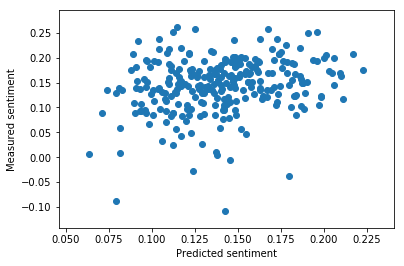

In [308]:
plt.scatter(predicted_senti, fit_df['compound_mean_mean'])
plt.xlabel('Predicted sentiment')
plt.ylabel('Measured sentiment');

#### Regression model with more performance features

In [310]:
import statsmodels.api as sm

# 
fit_df = join_df.query('Race != "A" and Race != "R"')
performance_model = sm.OLS( fit_df['compound_mean_mean'].values, fit_df[['TRB%', 'AST%','BLK%', 'STL%', 'OWS', 'DWS', 'youth', 'oldness', 'Wins', 'W', 'M', 'short', 'tall']] ).fit()

In [311]:
performance_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     128.5
Date:                Sun, 16 Sep 2018   Prob (F-statistic):          1.57e-105
Time:                        17:23:45   Log-Likelihood:                 398.25
No. Observations:                 275   AIC:                            -770.5
Df Residuals:                     262   BIC:                            -723.5
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
TRB%           0.0014      0.001      1.404      0.161      -0.001       0.003
AST%           0.0005      0.000      1.130      0.260      -0.000       0.001
BLK%           0.0041      0.003      1.300      0.195      -0.002       0.010
STL%           0.0145      0.005      2.743      0.007       0.004       0.025
OWS            0.0003      0.002      0.130      0.896      -0.004       0.005
DWS           -0.0031      0.004     -0.716      0.475      -0.012       0.005
youth          0.0100      0.002      5.683      0.000       0.007       0.013
oldness        0.0042      0.001      3.035      0.003       0.001       0.007
Wins           0.0013      0.000      5.688      0.000       0.001       0.002
W              0.0155      0.009      1.709      0.089      -0.002       0.033
M              0.0100      0.021      0.471      0.638      -0.032       0.052
short          0.0375      0.019      1.927      0.055      -0.001       0.076
tall           0.0075      0.010      0.718      0.473      -0.013       0.028
==============================================================================
Omnibus:                       45.897   Durbin-Watson:                   1.814
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               97.230
Skew:                          -0.836   Prob(JB):                     7.71e-22
Kurtosis:                       5.385   Cond. No.                         291.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Regression model including teams

In [245]:
import statsmodels.api as sm

# 
fit_df = join_df.query('Race != "A" and Race != "R"')
team_model = sm.OLS( fit_df['compound_mean_mean'].values, pd.concat([fit_df[['PER', 'youth', 'oldness', 'Wins', 'W', 'M', 'short', 'tall']], fit_df.iloc[:, -29:]], axis=1) ).fit()

Regression model for sentiment with features for performance, age, team wins, race, and height, and team

In [246]:
team_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     1.447
Date:                Sun, 16 Sep 2018   Prob (F-statistic):             0.0583
Time:                        17:01:30   Log-Likelihood:                 431.93
No. Observations:                 275   AIC:                            -791.9
Df Residuals:                     239   BIC:                            -661.6
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
PER            0.0006      0.001      0.896      0.371      -0.001       0.002
youth          0.0070      0.002      3.997      0.000       0.004       0.010
oldness        0.0024      0.001      1.744      0.082      -0.000       0.005
Wins           0.0025      0.000      9.778      0.000       0.002       0.003
W              0.0075      0.009      0.870      0.385      -0.009       0.024
M              0.0150      0.020      0.732      0.465      -0.025       0.055
short          0.0205      0.019      1.065      0.288      -0.017       0.059
tall           0.0064      0.008      0.853      0.394      -0.008       0.021
ATL            0.0530      0.025      2.156      0.032       0.005       0.101
BOS           -0.0091      0.016     -0.557      0.578      -0.041       0.023
BRK            0.0221      0.020      1.077      0.283      -0.018       0.062
CHI            0.0679      0.018      3.833      0.000       0.033       0.103
CLE           -0.0155      0.016     -0.957      0.340      -0.047       0.016
DAL            0.0621      0.024      2.637      0.009       0.016       0.109
DEN           -0.0014      0.018     -0.081      0.936      -0.036       0.033
DET            0.0461      0.020      2.279      0.024       0.006       0.086
GSW           -0.0450      0.014     -3.161      0.002      -0.073      -0.017
HOU           -0.0574      0.017     -3.341      0.001      -0.091      -0.024
IND            0.0035      0.020      0.177      0.860      -0.036       0.043
LAC            0.0334      0.019      1.737      0.084      -0.004       0.071
LAL           -0.0037      0.016     -0.235      0.814      -0.035       0.027
MEM            0.0538      0.023      2.373      0.018       0.009       0.099
MIA           -0.0088      0.016     -0.548      0.584      -0.040       0.023
MIL           -0.0025      0.017     -0.149      0.882      -0.036       0.031
MIN           -0.0096      0.017     -0.569      0.570      -0.043       0.024
NOP            0.0176      0.020      0.872      0.384      -0.022       0.057
NYK            0.0460      0.017      2.725      0.007       0.013       0.079
OKC           -0.0168      0.015     -1.118      0.265      -0.046       0.013
ORL            0.0336      0.019      1.818      0.070      -0.003       0.070
PHI           -0.0190      0.017     -1.128      0.260      -0.052       0.014
PHO            0.0170      0.018      0.927      0.355      -0.019       0.053
POR            0.0101      0.018      0.565      0.573      -0.025       0.045
SAC            0.0696      0.020      3.499      0.001       0.030       0.109
SAS           -0.0095      0.015     -0.632      0.528      -0.039       0.020
TOR           -0.0309      0.016     -1.879      0.062      -0.063       0.002
UTA           -0.0149      0.017     -0.867      0.387      -0.049       0.019
WA